In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import *
import torchvision
import torchvision.transforms as transforms
import os
import argparse
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.01




In [11]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=2):
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [5]:

# Data Preparation
print('==> Preparing CIFAKE data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Custom dataset class for CIFAKE
class CIFAKE(torchvision.datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(CIFAKE, self).__init__(root, transform=transform)
        # Map class names to indices
        self.class_to_idx = {'REAL': 0, 'FAKE': 1}
        self.idx_to_class = {0: 'REAL', 1: 'FAKE'}

# Load CIFAKE dataset
train_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
test_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

trainset = CIFAKE(root=train_path, transform=transform_train)
testset = CIFAKE(root=test_path, transform=transform_test)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)


==> Preparing CIFAKE data..


==> Building model..


Epoch 1: 100%|██████████| 782/782 [04:12<00:00,  3.10batch/s, accuracy=88.4, loss=0.353]


Epoch 1 training time: 252.34 seconds


Test 1: 100%|██████████| 200/200 [00:45<00:00,  4.44batch/s, accuracy=87.1, loss=0.0598] 


Test 1 time: 45.06 seconds


Epoch 2: 100%|██████████| 782/782 [04:12<00:00,  3.10batch/s, accuracy=92.7, loss=0.0886]


Epoch 2 training time: 252.53 seconds


Test 2: 100%|██████████| 200/200 [00:45<00:00,  4.40batch/s, accuracy=92.9, loss=0.236] 


Test 2 time: 45.44 seconds


Epoch 3: 100%|██████████| 782/782 [04:11<00:00,  3.11batch/s, accuracy=93.7, loss=0.0661]


Epoch 3 training time: 251.43 seconds


Test 3: 100%|██████████| 200/200 [00:45<00:00,  4.41batch/s, accuracy=94.5, loss=0.123] 


Test 3 time: 45.32 seconds


Epoch 4: 100%|██████████| 782/782 [04:11<00:00,  3.11batch/s, accuracy=94.5, loss=0.172] 


Epoch 4 training time: 251.66 seconds


Test 4: 100%|██████████| 200/200 [00:45<00:00,  4.39batch/s, accuracy=95, loss=0.189]   


Test 4 time: 45.61 seconds


Epoch 5: 100%|██████████| 782/782 [04:10<00:00,  3.12batch/s, accuracy=95, loss=0.349]   


Epoch 5 training time: 250.80 seconds


Test 5: 100%|██████████| 200/200 [00:44<00:00,  4.48batch/s, accuracy=95.6, loss=0.0963]


Test 5 time: 44.66 seconds


Epoch 6: 100%|██████████| 782/782 [04:09<00:00,  3.13batch/s, accuracy=95.3, loss=0.08]  


Epoch 6 training time: 249.56 seconds


Test 6: 100%|██████████| 200/200 [00:44<00:00,  4.45batch/s, accuracy=94.2, loss=0.33]  


Test 6 time: 44.98 seconds


Epoch 7: 100%|██████████| 782/782 [04:09<00:00,  3.13batch/s, accuracy=95.7, loss=0.12]  


Epoch 7 training time: 249.91 seconds


Test 7: 100%|██████████| 200/200 [00:44<00:00,  4.45batch/s, accuracy=96.4, loss=0.0917]


Test 7 time: 44.98 seconds


Epoch 8: 100%|██████████| 782/782 [04:10<00:00,  3.13batch/s, accuracy=95.9, loss=0.103] 


Epoch 8 training time: 250.07 seconds


Test 8: 100%|██████████| 200/200 [00:45<00:00,  4.41batch/s, accuracy=95.6, loss=0.0871] 


Test 8 time: 45.38 seconds


Epoch 9: 100%|██████████| 782/782 [04:10<00:00,  3.12batch/s, accuracy=96.1, loss=0.222] 


Epoch 9 training time: 250.44 seconds


Test 9: 100%|██████████| 200/200 [00:45<00:00,  4.44batch/s, accuracy=96.9, loss=0.118] 


Test 9 time: 45.00 seconds


Epoch 10: 100%|██████████| 782/782 [04:10<00:00,  3.13batch/s, accuracy=96.4, loss=0.182] 


Epoch 10 training time: 250.06 seconds


Test 10: 100%|██████████| 200/200 [00:45<00:00,  4.43batch/s, accuracy=96, loss=0.13]    


Test 10 time: 45.20 seconds
Total training time: 2960.45 seconds
Accuracy of the network on the test images: 96 %


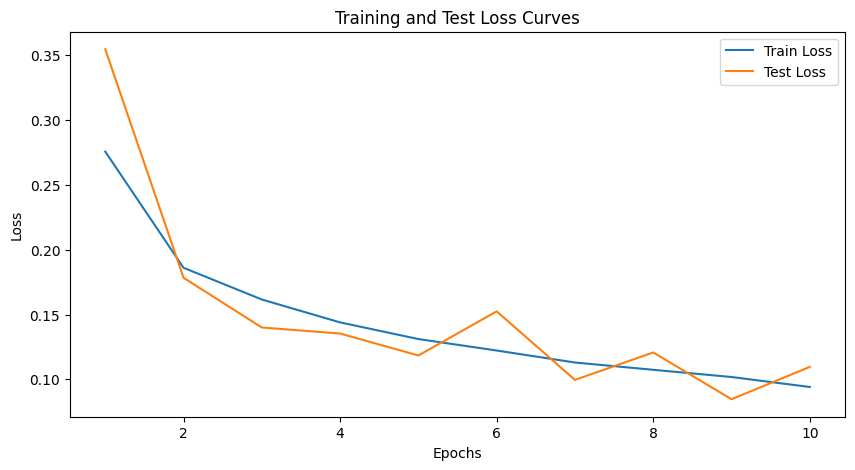

Creating confusion matrix:   0%|          | 0/200 [00:44<?, ?batch/s]


Confusion matrix generation time: 44.22 seconds


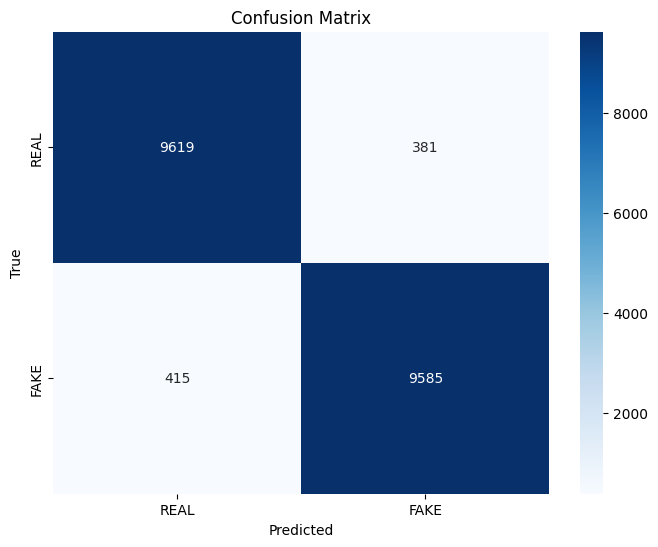

==> Saving model...
Model saved in 0.16 seconds


In [15]:
# Add these imports at the top of your file
import time
from tqdm import tqdm

# Model
print('==> Building model..')
net = ResNet18(num_classes=2)  # 2 classes for REAL and FAKE
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Training and Test Functions with progress bars
def train(epoch, net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    start_time = time.time()
    
    with tqdm(trainloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")
        for batch_idx, (inputs, targets) in enumerate(tepoch):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            tepoch.set_postfix(loss=loss.item(), accuracy=100.*correct/total)
    
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1} training time: {epoch_time:.2f} seconds")
    return train_loss/len(trainloader)

def test(epoch, net):
    global acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    start_time = time.time()
    
    with torch.no_grad():
        with tqdm(testloader, unit="batch") as tepoch:
            tepoch.set_description(f"Test {epoch+1}")
            for batch_idx, (inputs, targets) in enumerate(tepoch):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                # Update progress bar
                tepoch.set_postfix(loss=loss.item(), accuracy=100.*correct/total)
    
    test_time = time.time() - start_time
    print(f"Test {epoch+1} time: {test_time:.2f} seconds")
    acc = 100 * correct / total
    return test_loss/len(testloader)

# Training Loop
train_losses = []
test_losses = []
epochs = 10

total_start_time = time.time()
for epoch in range(epochs):
    train_losses.append(train(epoch, net))
    test_losses.append(test(epoch, net))
    scheduler.step()

total_time = time.time() - total_start_time
print(f'Total training time: {total_time:.2f} seconds')
print('Accuracy of the network on the test images: %d %%' % (acc))

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, epochs+1), train_losses, label='Train Loss')
plt.plot(np.arange(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss Curves')
plt.savefig('training_curves.png')
plt.show()

# Confusion Matrix
def plot_confusion_matrix(model, data_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    start_time = time.time()
    
    with torch.no_grad():
        with tqdm(data_loader, unit="batch") as tepoch:
            tepoch.set_description("Creating confusion matrix")
            for images, labels in data_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(labels.cpu().numpy())
    
    cm_time = time.time() - start_time
    print(f"Confusion matrix generation time: {cm_time:.2f} seconds")
    
    cm = confusion_matrix(all_targets, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['REAL', 'FAKE'], 
                yticklabels=['REAL', 'FAKE'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

plot_confusion_matrix(net, testloader, device)

# Save the model
print("==> Saving model...")
model_save_time = time.time()
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, 'resnet18_model.pth')
print(f"Model saved in {time.time() - model_save_time:.2f} seconds")

In [20]:
from tqdm import tqdm
import time

# Modify the FGSM attack function to show progress (if used in loops)
def FGSM(net, x, y, eps):
    x_ = Variable(x.data, requires_grad=True)
    h_ = net(x_)
    cost = criterion(h_, y)
    net.zero_grad()
    cost.backward()

    pert = eps * x_.grad.detach().sign()
    x_adv = x_ + pert

    h_adv = net(x_adv)
    _, y_adv = torch.max(h_adv.data, 1)
    return x_adv, h_adv, y_adv, pert

epochs = 5

optimizer_adv = optim.SGD(net_adv.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler_adv = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_adv, T_max=200)

# Adversarial Training with FGSM - add progress bar
def train_adv(epoch, net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    eps = 8/255
    start_time = time.time()
    
    with tqdm(trainloader, unit="batch") as tepoch:
        tepoch.set_description(f"Adv Epoch {epoch+1}")
        for batch_idx, (inputs, targets) in enumerate(tepoch):
            inputs, targets = inputs.to(device), targets.to(device)

            inputs_ = Variable(inputs.data, requires_grad=True)
            h_ = net(inputs_)
            cost = criterion(h_, targets)
            net.zero_grad()
            cost.backward()

            pert = eps * inputs_.grad.detach().sign()
            x_adv = inputs_ + pert

            optimizer_adv.zero_grad()
            outputs = net_adv(x_adv)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer_adv.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            tepoch.set_postfix(loss=loss.item(), accuracy=100.*correct/total)
    
    epoch_time = time.time() - start_time
    print(f"Adv Epoch {epoch+1} time: {epoch_time:.2f} seconds")
    return train_loss/len(trainloader)

# Train adversarial model with progress
train_losses_adv = []
test_losses_adv = []
total_start_time = time.time()

for epoch in range(epochs):
    train_losses_adv.append(train_adv(epoch, net))
    test_losses_adv.append(test(epoch, net_adv))
    scheduler_adv.step()

total_time = time.time() - total_start_time
print(f'Total adversarial training time: {total_time:.2f} seconds')
print('Accuracy of adversarially-trained network: %d %%' % (acc))

# Evaluate against FGSM attacks with progress
def test_adv(net, net_adv, eps):
    net.train()
    net_adv.eval()
    correct = 0
    total = 0
    start_time = time.time()
    
    with tqdm(testloader, unit="batch") as tepoch:
        tepoch.set_description(f"FGSM Test (ε={eps:.4f})")
        for batch_idx, (inputs, targets) in enumerate(tepoch):
            inputs, targets = inputs.to(device), targets.to(device)
            x_adv, _, _, _ = FGSM(net, inputs, targets, eps)
            
            with torch.no_grad():
                outputs = net_adv(x_adv)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
            # Update progress bar
            tepoch.set_postfix(accuracy=100.*correct/total)
    
    test_time = time.time() - start_time
    print(f"FGSM test (ε={eps:.4f}) time: {test_time:.2f} seconds")
    return 100 * correct / total

print("Evaluating against FGSM attacks:")
for eps in [4/255, 8/255, 12/255]:
    accuracy = test_adv(net, net_adv, eps)
    print(f"Epsilon: {eps:.4f}, Accuracy: {accuracy:.2f}%")





Adv Epoch 1: 100%|██████████| 782/782 [08:09<00:00,  1.60batch/s, accuracy=88.3, loss=0.414]


Adv Epoch 1 time: 489.29 seconds


Test 1: 100%|██████████| 200/200 [00:45<00:00,  4.44batch/s, accuracy=91.9, loss=0.199]


Test 1 time: 45.01 seconds


Adv Epoch 2: 100%|██████████| 782/782 [08:02<00:00,  1.62batch/s, accuracy=85.8, loss=0.274]


Adv Epoch 2 time: 482.00 seconds


Test 2: 100%|██████████| 200/200 [00:44<00:00,  4.47batch/s, accuracy=91.7, loss=0.237]


Test 2 time: 44.78 seconds


Adv Epoch 3: 100%|██████████| 782/782 [08:01<00:00,  1.62batch/s, accuracy=90.5, loss=0.383] 


Adv Epoch 3 time: 481.61 seconds


Test 3: 100%|██████████| 200/200 [00:44<00:00,  4.47batch/s, accuracy=88.9, loss=0.667] 


Test 3 time: 44.72 seconds


Adv Epoch 4: 100%|██████████| 782/782 [08:02<00:00,  1.62batch/s, accuracy=92.5, loss=0.173] 


Adv Epoch 4 time: 482.34 seconds


Test 4: 100%|██████████| 200/200 [00:44<00:00,  4.48batch/s, accuracy=92.5, loss=0.227] 


Test 4 time: 44.63 seconds


Adv Epoch 5: 100%|██████████| 782/782 [08:01<00:00,  1.62batch/s, accuracy=94.1, loss=0.156] 


Adv Epoch 5 time: 481.53 seconds


Test 5: 100%|██████████| 200/200 [00:44<00:00,  4.50batch/s, accuracy=91.3, loss=0.346] 


Test 5 time: 44.46 seconds
Total adversarial training time: 2640.39 seconds
Accuracy of adversarially-trained network: 91 %
Evaluating against FGSM attacks:


FGSM Test (ε=0.0157): 100%|██████████| 200/200 [02:21<00:00,  1.42batch/s, accuracy=93.2]


FGSM test (ε=0.0157) time: 141.13 seconds
Epsilon: 0.0157, Accuracy: 93.22%


FGSM Test (ε=0.0314): 100%|██████████| 200/200 [02:19<00:00,  1.43batch/s, accuracy=93.1]


FGSM test (ε=0.0314) time: 139.38 seconds
Epsilon: 0.0314, Accuracy: 93.14%


FGSM Test (ε=0.0471): 100%|██████████| 200/200 [02:19<00:00,  1.44batch/s, accuracy=92.7]

FGSM test (ε=0.0471) time: 139.23 seconds
Epsilon: 0.0471, Accuracy: 92.70%


In [23]:

epochs = 5


# PGD Attack Function with progress
def PGD(net, x, y, alpha, epsilon, iter):
    delta = torch.zeros_like(x, requires_grad=True)
    for i in range(iter):
        loss = criterion(net(x + delta), y)
        loss.backward()
        delta.data = (delta + x.shape[0]*alpha*delta.grad.data).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    pert = delta.detach()
    x_adv = x + pert
    h_adv = net(x_adv)
    _, y_adv = torch.max(h_adv.data, 1)
    return x_adv, h_adv, y_adv, pert

# Adversarial Training with PGD - add progress bar
def train_pgd(epoch, net, alpha, epsilon, iter):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    start_time = time.time()
    
    with tqdm(trainloader, unit="batch") as tepoch:
        tepoch.set_description(f"PGD Epoch {epoch+1}")
        for batch_idx, (inputs, targets) in enumerate(tepoch):
            inputs, targets = inputs.to(device), targets.to(device)
            x_adv, _, _, _ = PGD(net, inputs, targets, alpha, epsilon, iter)

            optimizer_pgd.zero_grad()
            outputs = net_pgd(x_adv)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer_pgd.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            tepoch.set_postfix(loss=loss.item(), accuracy=100.*correct/total)
    
    epoch_time = time.time() - start_time
    print(f"PGD Epoch {epoch+1} time: {epoch_time:.2f} seconds")
    return train_loss/len(trainloader)

# Adversarial Training with PGD
print('==> Building PGD adversarial model..')
net_pgd = ResNet18(num_classes=2).to(device)
if device == 'cuda':
    net_pgd = torch.nn.DataParallel(net_pgd)
    cudnn.benchmark = True

optimizer_pgd = optim.SGD(net_pgd.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler_pgd = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_pgd, T_max=200)
# Train PGD model with progress
train_losses_pgd = []
test_losses_pgd = []
alpha = 3/255
epsilon = 8/255
iter = 3
total_start_time = time.time()

for epoch in range(epochs):
    train_losses_pgd.append(train_pgd(epoch, net_pgd, alpha, epsilon, iter))
    test_losses_pgd.append(test(epoch, net_pgd))
    scheduler_pgd.step()

total_time = time.time() - total_start_time
print(f'Total PGD training time: {total_time:.2f} seconds')
print('Accuracy of PGD-trained network: %d %%' % (acc))


# Evaluate PGD model against PGD attacks with progress
def test_pgd(net, net_pgd, alpha, eps, iter):
    net.train()
    net_pgd.eval()
    correct = 0
    total = 0
    start_time = time.time()
    
    with tqdm(testloader, unit="batch") as tepoch:
        tepoch.set_description(f"PGD Test (iter={iter})")
        for batch_idx, (inputs, targets) in enumerate(tepoch):
            inputs, targets = inputs.to(device), targets.to(device)
            x_adv, _, _, _ = PGD(net, inputs, targets, alpha, eps, iter)

            with torch.no_grad():
                outputs = net_pgd(x_adv)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
            # Update progress bar
            tepoch.set_postfix(accuracy=100.*correct/total)
    
    test_time = time.time() - start_time
    print(f"PGD test (iter={iter}) time: {test_time:.2f} seconds")
    return 100 * correct / total

print("Evaluating against PGD attacks:")
for iter in [3, 7, 12]:
    accuracy = test_pgd(net, net_pgd, alpha, epsilon, iter)
    print(f"Iterations: {iter}, Accuracy: {accuracy:.2f}%")

# Save models with progress indication
print("Saving models...")
start_time = time.time()
torch.save(net.state_dict(), 'natural_model.pth')
torch.save(net_adv.state_dict(), 'fgsm_model.pth')
torch.save(net_pgd.state_dict(), 'pgd_model.pth')
print(f"Models saved in {time.time() - start_time:.2f} seconds")

==> Building PGD adversarial model..


PGD Epoch 1: 100%|██████████| 782/782 [20:12<00:00,  1.55s/batch, accuracy=88.1, loss=0.521]


PGD Epoch 1 time: 1212.32 seconds


Test 1: 100%|██████████| 200/200 [00:46<00:00,  4.34batch/s, accuracy=91.6, loss=0.358]


Test 1 time: 46.07 seconds


PGD Epoch 2: 100%|██████████| 782/782 [20:02<00:00,  1.54s/batch, accuracy=92.7, loss=0.277] 


PGD Epoch 2 time: 1202.42 seconds


Test 2: 100%|██████████| 200/200 [00:46<00:00,  4.28batch/s, accuracy=93.8, loss=0.192] 


Test 2 time: 46.76 seconds


PGD Epoch 3: 100%|██████████| 782/782 [20:00<00:00,  1.54s/batch, accuracy=93.8, loss=0.208] 


PGD Epoch 3 time: 1200.52 seconds


Test 3: 100%|██████████| 200/200 [00:47<00:00,  4.24batch/s, accuracy=93.6, loss=0.289] 


Test 3 time: 47.13 seconds


PGD Epoch 4: 100%|██████████| 782/782 [20:13<00:00,  1.55s/batch, accuracy=94.3, loss=0.219] 


PGD Epoch 4 time: 1213.76 seconds


Test 4: 100%|██████████| 200/200 [00:45<00:00,  4.35batch/s, accuracy=95.3, loss=0.201] 


Test 4 time: 45.97 seconds


PGD Epoch 5: 100%|██████████| 782/782 [20:02<00:00,  1.54s/batch, accuracy=94.9, loss=0.0589]


PGD Epoch 5 time: 1202.59 seconds


Test 5: 100%|██████████| 200/200 [00:46<00:00,  4.31batch/s, accuracy=95, loss=0.173]   


Test 5 time: 46.38 seconds
Total PGD training time: 6263.94 seconds
Accuracy of PGD-trained network: 95 %
Evaluating against PGD attacks:


PGD Test (iter=3): 100%|██████████| 200/200 [04:10<00:00,  1.25s/batch, accuracy=94.6]


PGD test (iter=3) time: 250.36 seconds
Iterations: 3, Accuracy: 94.63%


PGD Test (iter=7): 100%|██████████| 200/200 [07:40<00:00,  2.30s/batch, accuracy=94.2]


PGD test (iter=7) time: 460.67 seconds
Iterations: 7, Accuracy: 94.17%


PGD Test (iter=12): 100%|██████████| 200/200 [12:03<00:00,  3.62s/batch, accuracy=93.6]


PGD test (iter=12) time: 723.74 seconds
Iterations: 12, Accuracy: 93.62%
Saving models...
Models saved in 0.22 seconds
